<center>
    
# Email Spam/Ham Classification 
---------
</center>
<img src="https://raw.githubusercontent.com/deepankarkotnala/Email-Spam-Ham-Classifier-NLP/master/images/email_spam_ham.png"  width="900" align="left"/>


-------
### Read Text and Clean It

In [1]:
import nltk
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string

from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import GridSearchCV

In [2]:
# Reading the data
data = pd.read_csv("EmailSpamCollection.tsv", sep='\t')
data.columns = ['label', 'body_text']

In [3]:
# Getting stopwords and PorterStemmer for stemming from nltk library
stopwords = nltk.corpus.stopwords.words('english')
ps = nltk.PorterStemmer()

In [4]:
# Feature Engineering
def count_punct(text):
    count = sum([1 for char in text if char in string.punctuation])
    return round(count/(len(text) - text.count(" ")), 3)*100

data['body_len'] = data['body_text'].apply(lambda x: len(x) - x.count(" "))
data['punct%'] = data['body_text'].apply(lambda x: count_punct(x))

In [5]:
# Cleaning the data
# Removing punctuations, tokenization, removing stopwords and stemming the text

def clean_text(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    text = [ps.stem(word) for word in tokens if word not in stopwords]
    return text

In [6]:
# Vectorizing the data using TF_IDF Vectorizer

tfidf_vect = TfidfVectorizer(analyzer=clean_text)
X_tfidf = tfidf_vect.fit_transform(data['body_text'])

# Concatenating all the features into one DataFrame
X_features = pd.concat([data['body_len'], data['punct%'], pd.DataFrame(X_tfidf.toarray())], axis=1)
X_features.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,8094,8095,8096,8097,8098,8099,8100,8101,8102,8103
0,128,4.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,49,4.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,62,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,28,7.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,135,4.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Model Building - Random Forest Classifier

In [46]:
# Splitting the data into training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_features, data['label'], test_size=0.2, random_state=100)

In [194]:
# Creating a general model with default parameter values

n =42

rf = RandomForestClassifier(random_state=n)
rf_model = rf.fit(X_train, y_train)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [195]:
# Checking feature importance
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.07212615325452483, 1803),
 (0.029103850758799593, 'body_len'),
 (0.02617485751624881, 7350),
 (0.020712707851218554, 2031),
 (0.019105874800647453, 6285),
 (0.018845731574975336, 3134),
 (0.018663357897397054, 4796),
 (0.017433081626873882, 6746),
 (0.014643261270863402, 6971),
 (0.011208436166505648, 5078)]

In [196]:
# Predicting the results using the model on test dataset
y_pred = rf_model.predict(X_test)

# Checking the Precision, Recall and Accuracy metrics for Model Evaluation
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')

` # pos_label : we need to tell it what our POSITIVE label is. `

` # We are predicting spam here, so we will tell it that SPAM is positive label.`

In [197]:
print('Precision: {} / Recall: {} / Accuracy: {}'.format(round(precision, 3),
                                                        round(recall, 3),
                                                        round((y_pred==y_test).sum() / len(y_pred),3)))

Precision: 1.0 / Recall: 0.772 / Accuracy: 0.967


In [198]:
# Creating a function to generate a Confusion matrix and calculate the Accuracy, Precision, Recall and f1_score

def generate_cf_mat_and_heatmap(model,x,y):
    
    model_string = str(model)
    print(' '.join(model_string.split('(')[:1])) # Extracting the model name from the model summary
    print('-----------------------------------------')
    
    pred = model.predict(x)
    
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, cmap='YlGnBu') # cmap -- Y low, G neutral, B upper , maybe
    
    acc = accuracy_score(y, pred)
    p_score = precision_score(y, pred, pos_label='spam')
    r_score = recall_score(y, pred, pos_label='spam')
    f_score = f1_score(y, pred, pos_label='spam')
    
    max_len = 14
    print('Accuracy'.ljust(10),':', acc)
    print('Precision'.ljust(10),':', p_score)
    print('Recall'.ljust(10),':', r_score)
    print('F1_Score'.ljust(10),':',f_score)
    print('-----------------------------------------')

RandomForestClassifier
-----------------------------------------
Accuracy   : 0.966786355475763
Precision  : 1.0
Recall     : 0.7716049382716049
F1_Score   : 0.8710801393728224
-----------------------------------------


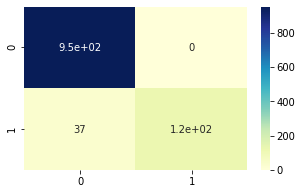

In [199]:
# Calling the function 
generate_cf_mat_and_heatmap(rf_model, X_test, y_test)

-----------
### Tuning the Random Forest Classifier using GridSearchCV

In [213]:
param_grid = { 
    'random_state':[42],
    'n_estimators': [100, 120, 150, 160],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [None,4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy', cv= 5) #verbose= 10 will show the progress details
CV_rfc.fit(X_train, y_train)

In [114]:
CV_rfc.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'n_estimators': 120}

## Again building the model using the suggested parameters

In [201]:
# After a few alterations to the above suggested parameters by GridSearchCV, 
# I will build the model with the below optimum values of the parameters.

rf = RandomForestClassifier(random_state=42, criterion='gini',max_depth= None, max_features= 'sqrt',n_estimators=150)
rf_model = rf.fit(X_train, y_train)

In [202]:
sorted(zip(rf_model.feature_importances_, X_train.columns), reverse=True)[0:10]

[(0.042490722160780287, 'body_len'),
 (0.0388847186292585, 1803),
 (0.03124259562593848, 7350),
 (0.02469670478065958, 3134),
 (0.02322939232973355, 4796),
 (0.020685975305042233, 2031),
 (0.016170377655434137, 5724),
 (0.01595013541725798, 6285),
 (0.014010746085019597, 7027),
 (0.011368288569459529, 5988)]

In [203]:
y_pred = rf_model.predict(X_test)
precision, recall, fscore, support = score(y_test, y_pred, pos_label='spam', average='binary')

In [210]:
def generate_cf_mat_and_heatmap(model,x,y):
    
    model_string = str(model)
    print(' '.join(model_string.split('(')[:1])) # Extracting the model name from the model summary
    print('-----------------------------------------')
    
    pred = model.predict(x)
    
    cm = confusion_matrix(y, pred)
    plt.figure(figsize=(5,3))
    sns.heatmap(cm, annot=True, cmap='YlGnBu') # cmap -- Y low, G neutral, B upper , maybe
    
    acc = accuracy_score(y, pred)
    p_score = precision_score(y, pred, pos_label='spam')
    r_score = recall_score(y, pred, pos_label='spam')
    f_score = f1_score(y, pred, pos_label='spam')
    
    max_len = 14
    print('Accuracy'.ljust(10),':', round(acc,2))
    print('Precision'.ljust(10),':', round(p_score,2))
    print('Recall'.ljust(10),':', round(r_score,2))
    print('F1_Score'.ljust(10),':',round(f_score,2))
    print('-----------------------------------------')

RandomForestClassifier
-----------------------------------------
Accuracy   : 0.98
Precision  : 1.0
Recall     : 0.84
F1_Score   : 0.91
-----------------------------------------


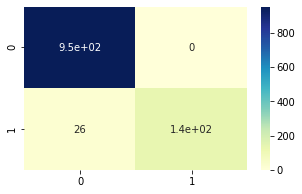

In [211]:
generate_cf_mat_and_heatmap(rf_model, X_test, y_test)